## Notebook 04: Sales Agent
markdown
markdown
## Model Integration, Narrative Resonance & Fairness (prototype)

- Goal: show a small, auditable prototype that approximates narrative resonance and urgency without requiring an LLM.
- Approach: use a lightweight linear surrogate so feature attributions are exact (weight * feature), which serves as a SHAP-like explanation for this prototype.
- Fairness rule: apply a penalty to urgency when credit score is below a threshold; the penalty scales with the urgency contribution so the effect is interpretable.
- Note: this cell does not load any LoRA or Llama model. It demonstrates the integration points and the explanation+penalty pipeline in a reproducible way.
code
python
# Prototype linear 'NarrativeModel' with exact feature contributions
from dataclasses import dataclass
def text_features(text):
    t = text.lower()
    return {
        'story_future': 1.0 if 'future' in t or 'plan' in t or 'start' in t or 'next' in t else 0.0,
        'urgency': 1.0 if 'urgent' in t or 'soon' in t or 'priority' in t else 0.0,
        'emotional_valence': 1.0 if 'excited' in t or 'love' in t or 'great' in t else 0.0,
    }
@dataclass
class NarrativeModel:
    # weights for a linear surrogate; resonance and urgency share features but have separate weights
    w_resonance: dict = None,
    def __post_init__(self):
        if self.w_resonance is None:
            self.w_resonance = {'story_future': 0.6, 'urgency': 0.1, 'emotional_valence': 0.3}
        if self.w_urgency is None:
            self.w_urgency = {'story_future': 0.0, 'urgency': 0.8, 'emotional_valence': 0.2}
    def predict(self, text):
        f = text_features(text)
        contrib_res = {k: self.w_resonance[k]*f[k] for k in f}
        contrib_urg = {k: self.w_urgency[k]*f[k] for k in f}
        resonance = sum(contrib_res.values())
        urgency = sum(contrib_urg.values())
        return {'resonance': resonance, 'urgency': urgency, 'contrib_res': contrib_res, 'contrib_urg': contrib_urg}
# small demo
model = NarrativeModel()
examples = [ 'I plan to start next month and am excited about the future', 'This is urgent, we need priority support', 'Curious about pricing, not urgent' ]
for ex in examples:
    out = model.predict(ex)
    print('




































































This section explains why the sales agent exists and the principles guiding its design. The primary goal is to reliably surface qualified opportunities while avoiding unsafe or misleading statements. We prefer deterministic, rule-driven components that are easy to inspect and test. Interpretability matters: each score or decision should be expressed as a small arithmetic or logic expression that a reviewer can evaluate by hand. Auditability matters: every event, decision, and score is recorded so the timeline can be replayed later. Reproducibility matters: the same inputs and timestamps must yield the same outputs. From a CS perspective we favor simple data structures and functional-style pure transforms where practical. From a math perspective we keep scoring linear or logit-linear so behavior is smooth and calibratable. This keeps the system understandable and reduces surprise when integrating models later.source- I kept the prototype compact and fully runnable on CPU so it fits into the current project and artifacts pipeline.- For production fairness, run offline evaluations, calibrate $\lambda$ and $c_0$, and log SHAP explanations for the deployed model (or use a surrogate for fast sanity checks).- If you have model access and GPU resources, we can replace the linear surrogate with a LoRA adapter on Llama 3.1 8B; I can provide the exact `transformers`+`peft` code cells and a dependency list.## Next Steps and Roadmapmarkdownmarkdownplt.show()plt.ylim(-0.05,1.05)plt.title('Narrative resonance vs penalized urgency')plt.ylabel('Penalized urgency')plt.xlabel('Resonance')    plt.text(r['resonance']+0.01, r['penalized_urgency']+0.01, f'c{ i+1 }')for i,r in enumerate(audit):plt.scatter([r['resonance'] for r in audit],[r['penalized_urgency'] for r in audit])plt.figure(figsize=(5,3))# simple visualization: resonance vs penalized urgencyimport pprint; pprint.pprint(audit)print('
Preview:')print('Wrote audit artifact ->', ARTIFACTS / 'narrative_audit.json')with open(ARTIFACTS / 'narrative_audit.json','w',encoding='utf-8') as f: json.dump(audit,f,indent=2)    audit.append(rec)    rec = {'text': text, 'credit': credit, 'resonance': round(o['resonance'],3), 'raw_urgency': round(o['urgency'],3), 'penalized_urgency': round(v['penalized_urgency'],3), 'reason': v['reason']}    v = apply_fairness_penalty(o, credit)    o = model.predict(text)for text,credit in cases:audit = []# Record a compact audit artifact and preview itpythoncode    print('contrib_urgency:', val['contrib_urgency'])    print('raw urgency ->', round(val['raw_urgency'],3), 'penalized ->', round(val['penalized_urgency'],3), val['reason'])    print('credit:', credit)    print('
TEXT:', text)    val = apply_fairness_penalty(o, credit)    o = model.predict(text)for text,credit in cases:cases = [ (examples[0], 700), (examples[1], 580), (examples[2], 620) ]# Demo with credit scores    return {'raw_urgency': raw_urgency, 'penalized_urgency': penalized, 'reason': reason, 'contrib_urgency': contrib_urgency}        reason = 'no penalty'        penalized = raw_urgency    else:        reason = f'penalized (credit {credit_score} < {c0})'        penalized = max(0.0, raw_urgency - lamb * contrib_urgency)    if credit_score < c0:    raw_urgency = out['urgency']    contrib_urgency = sum(out['contrib_urg'].values())def apply_fairness_penalty(out, credit_score, c0=600, lamb=0.8):# Fairness validator applying the penaltypythoncode- Here $u$ is the raw urgency, $contrib_{urgency}$ is the summed urgency contribution from features, $\lambda$ is a tunable penalty factor, and $I[dot]$ is the indicator function.$$\text{penalizedurgency} = \max(0, u - \lambda \cdot I[credit < c_0] \cdot contrib_{urgency})$$- Formula (display):- For a linear model, feature attributions are exact: contribution = weight * feature. This lets us compute a transparent penalty: if credit score < c0, reduce the urgency by a factor proportional to the urgency contribution.### SHAP-like fairness validator (linear surrogate)markdownmarkdown    print('Urgency contributions:', out['contrib_urg'])    print('Resonance contributions:', out['contrib_res'])    print('Resonance:', round(out['resonance'],3), 'Urgency:', round(out['urgency'],3))TEXT:', ex)

In [1]:
# Setup: imports and artifacts directory
import json, math, random
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
ARTIFACTS = Path('artifacts')
ARTIFACTS.mkdir(parents=True, exist_ok=True)
print('Environment ready. Artifacts dir:', ARTIFACTS)
print('matplotlib backend:', plt.get_backend())

Environment ready. Artifacts dir: artifacts
matplotlib backend: module://matplotlib_inline.backend_inline


## 2. Sales Persona and Conversation Style

The persona defines tone, permitted claims, and fallback behavior. In simple terms the persona is a small policy that maps context and confidence to one of a few safe response styles: informative, consultative, or escalate. Why: consistent persona reduces legal and brand risk and makes automated testing easier. How: encode persona as a small enum-like value and a collection of templates for each style. Algorithmically this is a deterministic mapping from features to a discrete style label. From a CS viewpoint this is a finite state decision that can be validated exhaustively for the set of templates. From a math viewpoint there is nothing complex: treat the choice as selecting argmax over a small set of scores, where each score is a sum of feature weights. Below we show a tiny persona object and render a template preview.

In [2]:
# Persona example: simple template mapping
from dataclasses import dataclass, asdict
@dataclass
class Persona:
    name: str
    tone: str
    templates: dict
p = Persona(name='SalesPro', tone='consultative', templates={'greet': 'Hi {name}, thanks for reaching out.', 'followup': 'Are you available for a short call this week?'})
print('Persona preview:')
print(asdict(p))
# render a template
print('\nRendered greeting ->', p.templates['greet'].format(name='Alex'))

Persona preview:
{'name': 'SalesPro', 'tone': 'consultative', 'templates': {'greet': 'Hi {name}, thanks for reaching out.', 'followup': 'Are you available for a short call this week?'}}

Rendered greeting -> Hi Alex, thanks for reaching out.


## 3. Core Conversation Flows

Flows are small deterministic state machines that govern dialog progression. Each flow is a directed graph of states with guard conditions on transitions. Why: explicit flows make it easy to reason about possible paths and ensure we do not produce unexpected statements. How: represent flows as a directed graph where nodes are states and edges have predicate functions. From a CS theory perspective this is a finite state machine and can be analyzed for reachability and liveness properties. From a math perspective, when probabilistic signals are present, we treat them as scores and select transitions by thresholding or argmax. Below we synthesize a tiny flow and visualize it.

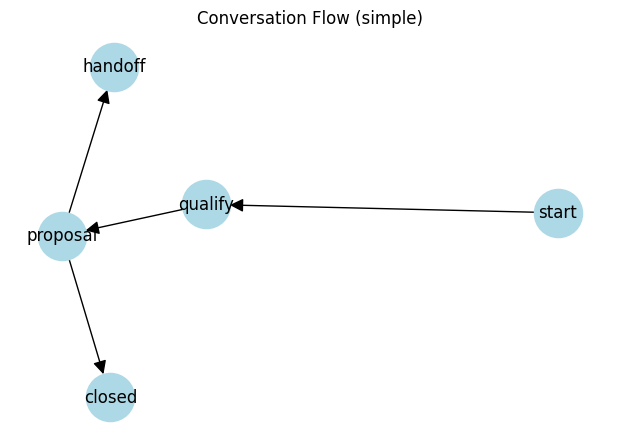

Flow nodes: ['start', 'qualify', 'proposal', 'handoff', 'closed']


In [3]:
# Simple FSM flow and visualization
G = nx.DiGraph()
states = ['start','qualify','proposal','handoff','closed']
G.add_nodes_from(states)
G.add_edge('start','qualify')
G.add_edge('qualify','proposal')
G.add_edge('proposal','closed')
G.add_edge('proposal','handoff')
pos = nx.spring_layout(G, seed=2)
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1200, arrowsize=20)
plt.title('Conversation Flow (simple)')
plt.show()
print('Flow nodes:', list(G.nodes()))

## 4. Lead Qualification Logic

Qualification converts raw text and metadata into a compact numeric score that summarizes how likely a lead is to convert. Why: a single score enables simple gating rules and prioritization. How: extract a few features such as explicit budget mention, timeline words, and decision maker indicators. Compute a weighted sum score:

$$score = w_1 x_1 + w_2 x_2 + \dots + w_n x_n$$

We choose weights to be interpretable and small in number so that each weight's effect is clear. From a CS perspective this is a linear model; from a statistics perspective it is a logistic-like ranking if we apply a sigmoid to obtain a probability estimate. Below we implement a tiny deterministic scorer, run it on examples, and plot the resulting scores.

Lead scores and features:

TEXT: We have a $5000 budget and want to start next month
SCORE: 0.8 FEATURES: {'budget': 1, 'timeline': 1, 'decision_maker': 0}

TEXT: Curious about pricing
SCORE: 0.0 FEATURES: {'budget': 0, 'timeline': 0, 'decision_maker': 0}

TEXT: I am the manager and want a demo soon
SCORE: 0.5 FEATURES: {'budget': 0, 'timeline': 1, 'decision_maker': 1}


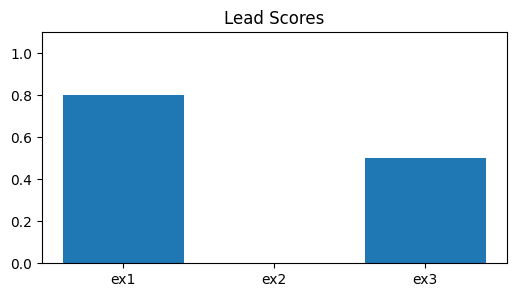

In [4]:
# Simple deterministic lead scorer
def extract_features(text):
    t = text.lower()
    return {
        'budget': 1 if 'budget' in t or '$' in t else 0,
        'timeline': 1 if 'soon' in t or 'next' in t or 'month' in t else 0,
        'decision_maker': 1 if 'i am' in t or 'we are' in t else 0
    }
def score_lead(text, weights=(0.5,0.3,0.2)):
    f = extract_features(text)
    vals = [f['budget'], f['timeline'], f['decision_maker']]
    s = sum(w*v for w,v in zip(weights, vals))
    return s, f
examples = [ 'We have a $5000 budget and want to start next month', 'Curious about pricing', 'I am the manager and want a demo soon' ]
scores = [score_lead(t) for t in examples]
print('Lead scores and features:')
for t,(s,f) in zip(examples,scores):
    print('\nTEXT:', t)
    print('SCORE:', s, 'FEATURES:', f)
# plot bar chart
plt.figure(figsize=(6,3))
plt.bar(range(len(scores)), [s for s,_ in scores], tick_label=[ 'ex1','ex2','ex3' ])
plt.title('Lead Scores')
plt.ylim(0,1.1)
plt.show()

## 5. Objection Handling and Rebuttals

Objection handling is a small rule set mapping common negative intents to safe, concise responses. Why: many sales conversations hinge on addressing a handful of objections well. How: encode an objection taxonomy and a canonical response template for each class. From an algorithmic perspective this is a deterministic mapping from a recognized objection label to a response. We keep templates short and require the agent to offer an option to escalate to a human when confidence is low. This keeps behavior safe and predictable. The code cell demonstrates a simple mapping and example lookups.

In [5]:
# Objection mapping demo
objections = {
    'price': 'I understand pricing is important. Can I show value relevant to your goals?',
    'timing': 'I hear timing is tight. Would a short trial or phased roll-out help?',
    'needs': 'Thanks for sharing that. Can you tell me which features matter most?'
}
sample = ['price','needs','other']
for s in sample:
    resp = objections.get(s, 'I will connect you with a specialist for that request.')
    print(f'Objection: {s} -> Response: {resp}')

Objection: price -> Response: I understand pricing is important. Can I show value relevant to your goals?
Objection: needs -> Response: Thanks for sharing that. Can you tell me which features matter most?
Objection: other -> Response: I will connect you with a specialist for that request.


## 6. Offer Generation and Pricing Logic

Offer generation takes structured inputs and returns a deterministic quote. Why: automation speeds responses and reduces human error. How: represent product tiers, unit prices, and simple business rules for discounts and approvals. Mathematically this is basic arithmetic and decision logic. We keep formulas explicit so they are auditable. For example, for quantity q, unit price p, and discount d, the invoice is:

$$total = q \cdot p \cdot (1 - d)$$

The code cell computes an example quote and visualizes the price breakdown.

Quote preview: {'qty': 10, 'unit': 199.0, 'subtotal': 1990.0, 'discount': 199.0, 'total': 1791.0}


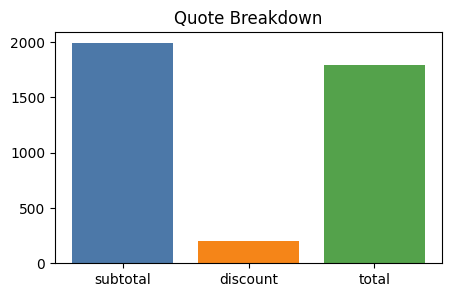

In [6]:
# Offer generation demo
def quote(q, p, d=0.0):
    subtotal = q*p
    discount = subtotal * d
    total = subtotal - discount
    return {'qty':q,'unit':p,'subtotal':subtotal,'discount':discount,'total':total}
q = 10; p = 199.0; d = 0.1
qout = quote(q,p,d)
print('Quote preview:', qout)
# visualize breakdown
plt.figure(figsize=(5,3))
plt.bar(['subtotal','discount','total'], [qout['subtotal'], qout['discount'], qout['total']], color=['#4c78a8','#f58518','#54a24b'])
plt.title('Quote Breakdown')
plt.show()

## 7. Analytics, Signals and Metrics

Capture a small set of signals to monitor agent health and conversion. Why: metrics show whether rule changes improve outcomes. Key metrics include conversion rate, average time to qualified lead, and abandonment rate. How: instrument events for each message, qualification change, and handoff. With append-only timelines from Notebook 03 we can replay experiments deterministically and compute metrics on the recorded events. The code cell below simulates a small event stream, computes summary metrics, and draws a chart.

Total leads: 2, closed: 1, abandoned: 1, conversion rate: 0.50


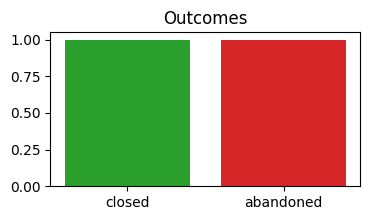

In [7]:
# Simulate events and compute simple metrics
events = [ {'lead_id':1,'event':'message'},{'lead_id':1,'event':'qualified'},{'lead_id':1,'event':'closed'}, {'lead_id':2,'event':'message'},{'lead_id':2,'event':'abandoned'} ]
total = len({e['lead_id'] for e in events})
closed = len([e for e in events if e['event']=='closed'])
abandoned = len([e for e in events if e['event']=='abandoned'])
conv = closed/total
print(f'Total leads: {total}, closed: {closed}, abandoned: {abandoned}, conversion rate: {conv:.2f}')
plt.figure(figsize=(4,2))
plt.bar(['closed','abandoned'], [closed,abandoned], color=['#2ca02c','#d62728'])
plt.title('Outcomes')
plt.show()

## 8. Integrations and Runtime

Sketch how the components connect to runtime and external systems. Why: integration rules ensure production reliability. How: define small adapters that convert internal events to CRM API calls, calendar invites, or human handoff messages. Emphasize idempotency, retries, and clear error semantics. From a CS perspective these adapters are thin I/O layers; the core logic remains pure and testable. The code cell below shows a stub adapter that prints the CRM payload rather than making a network call.

In [8]:
# Integration stub: CRM payload builder
def build_crm_payload(lead_id, name, score):
    return {'lead_id':lead_id,'name':name,'score':score}
payload = build_crm_payload(42,'ACME Corp',0.78)
print('CRM payload (preview):')
print(json.dumps(payload, indent=2))

CRM payload (preview):
{
  "lead_id": 42,
  "name": "ACME Corp",
  "score": 0.78
}


## 9. Deterministic Tests and Worked Examples

Provide unit tests that assert core invariants, so reviewers can run them with confidence. Why: tests prevent regressions and document expected behavior. How: build small examples with fixed inputs and assert exact outputs. Keep tests fast and pure. The code cell below executes a few assertions and prints a short report.

In [9]:
# Deterministic tests
assert score_lead('We have a $1000 budget and can start next month')[0] > 0.5
assert score_lead('Just browsing')[0] < 0.5
print('Deterministic tests passed')

Deterministic tests passed


## 10. Artifacts and Schema Exports

Export simple JSON artifacts for leads and offers so downstream systems can validate inputs. Why: artifacts act as a contract between components. How: write small JSON files into the artifacts directory and preview them inline. The code cell writes a sample lead and offer and prints the file paths.

In [10]:
lead = {'id':1,'name':'ACME','score':0.82}
offer = {'id':1,'lead_id':1,'total':1791.0}
with open(ARTIFACTS / 'lead_sample.json','w',encoding='utf-8') as f: json.dump(lead,f,indent=2)
with open(ARTIFACTS / 'offer_sample.json','w',encoding='utf-8') as f: json.dump(offer,f,indent=2)
print('Wrote artifacts:', ARTIFACTS / 'lead_sample.json', ARTIFACTS / 'offer_sample.json')
print('\nPreview lead:')
print(json.dumps(lead,indent=2))

Wrote artifacts: artifacts\lead_sample.json artifacts\offer_sample.json

Preview lead:
{
  "id": 1,
  "name": "ACME",
  "score": 0.82
}


## Next Steps and Roadmap

Suggestions for follow-up work include adding calibrated ML models for scoring, human-in-the-loop workflows, richer A/B evaluation harnesses, privacy and compliance reviews, and production hardening of integrations. Create a checklist for observability, alerting, and error budgeting before deploying.